# Data Wrangling with Behavioural Tasks - DV Level
Starting point:
- 848 datasets (18 tasks per model (minus the NON_IDEAL_OUTPUTS)) with all logprobs for all answer alternatives of each subtask for all ~1.500 tasks. 

Goal:
- find out and load DV for each participant
- calculate overall probability LLM assigns to participant
- weigh participants' DV with averaged probability, get DV per model per task
- Have 36 values per model! (one per (sub-) scale).

## Packages & Helpers

In [1]:
# packages
import pandas as pd
import numpy as np
import glob
import os
import seaborn as sns
import matplotlib.pyplot as plt
from utils import load_dataframes, filter_pred_prob
# load overall df
#all_data = pd.read_csv("processed_data/DVs_per_LLM.csv")

In [2]:
# Helpers

# filter out probability LLM assigned to real item answer  ------------------------------------------
def filter_pred_prob_including_key_logic(data, key1_column="box_1_key", key2_column= "box_2_key"):
    # Determine whether the human decision matches box_1 or box_2
    mask_box1 = data["human_decision"] == data[key1_column]
    mask_box2 = data["human_decision"] == data[key2_column]

    # Assign probability based on which box matches
    data["prob_pred"] = data["prob_1"].where(mask_box1, data["prob_2"].where(mask_box2, None))
    
    return data

def get_LLM_value_per_item_aggregated(data, dv = "pumps"):
    grouped = data.groupby(["experiment", "model"])
    score = (grouped[dv].apply(lambda x: (x * data.loc[x.index, "prob_pred"]).sum())
             / grouped["prob_pred"].sum())
    return score.reset_index(name="score")

def calc_one_DV_per_task(data, human_data, dv = "pumps"):
    # calculate avg probability per participant
    avg_prob_per_participant = data.groupby(["experiment", "model", "participant"])["prob_pred"].mean().reset_index()
    # merge human DV with probability per participant on participant
    avg_prob_per_participant = pd.merge(avg_prob_per_participant, 
                                        human_data[["partid", dv]], 
                                        left_on="participant",
                                        right_on="partid",
                                        how = "inner")
    # weigh DV by probability assigned per participant
    result = get_LLM_value_per_item_aggregated(avg_prob_per_participant, dv = dv)
    return result


## BART TASK

- Use human DVs (BART)
- calc avg probability per participant (over all balloons (i.e. rounds))
- weigh over all participants
- outcome: one DV BART value per model
    - (calc avg decision_num over 30 balloons per model in model_item_scores_BART to also have one DV BART) Compare the two methods

In [3]:
# load data
BART_data = load_dataframes(task_name="BART", path = "LLM_data")

Merged DataFrame shape: (74346712, 13)
Total models: 44


In [4]:
# load human data (for BART DV per person)
BART_human_data = pd.read_csv("orig_human_data/bart.csv")

In [5]:
# normalise answer option sum to one
BART_data["prob_pump"] = np.exp(BART_data["log_prob_pump"])/(np.exp(BART_data["log_prob_pump"]) + np.exp(BART_data["log_prob_stop"]))
BART_data["prob_stop"] = np.exp(BART_data["log_prob_stop"])/(np.exp(BART_data["log_prob_pump"]) + np.exp(BART_data["log_prob_stop"]))

In [6]:
# filter out probability LLM assigned to real item answer 
BART_data=filter_pred_prob(BART_data, human_col = "human_decision")

In [7]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_BART_aggregated = calc_one_DV_per_task(data = BART_data, human_data = BART_human_data, dv = "pumps")

In [8]:
# add_new_df
#all_data = pd.concat([all_data, model_item_scores_BART_aggregated], ignore_index=True)


## CCT TASK

In [9]:
# load data
CCT_data = load_dataframes(task_name="CCT")
# load human data (for CCT DV per person)
CCT_human_data = pd.read_csv("orig_human_data/cct_overt.csv")


Merged DataFrame shape: (23305362, 16)
Total models: 38


In [10]:
# normalise answer option sum to one
CCT_data["prob_flip"] = np.exp(CCT_data["log_prob_flip"])/(np.exp(CCT_data["log_prob_flip"]) + np.exp(CCT_data["log_prob_stop"]))
CCT_data["prob_stop"] = np.exp(CCT_data["log_prob_stop"])/(np.exp(CCT_data["log_prob_flip"]) + np.exp(CCT_data["log_prob_stop"]))

In [11]:
# filter out probability LLM assigned to real item answer 
CCT_data=filter_pred_prob(CCT_data, human_col = "human_decision")

In [12]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_CCT_aggregated = calc_one_DV_per_task(data = CCT_data, human_data = CCT_human_data, dv = "CCTncards")

In [13]:
# add_new_df
all_data = pd.merge(model_item_scores_BART_aggregated[["model", "score"]], 
                    model_item_scores_CCT_aggregated[["model", "score"]], 
                    on="model",
                    how = "outer",
                    suffixes = ["_BART", "_CCT"])


## DFD TASK

In [14]:
# load data
DFD_data = load_dataframes(task_name="DFD")
DFD_human_data = pd.read_csv("orig_human_data/dfd_perpers.csv")

Merged DataFrame shape: (554576, 9)
Total models: 46


In [15]:
# normalise answer option sum to one
DFD_data["prob_1"] = np.exp(DFD_data["log_prob_box_1"])/(np.exp(DFD_data["log_prob_box_1"]) + np.exp(DFD_data["log_prob_box_2"]))
DFD_data["prob_2"] = np.exp(DFD_data["log_prob_box_2"])/(np.exp(DFD_data["log_prob_box_1"]) + np.exp(DFD_data["log_prob_box_2"]))

In [16]:
# filter out probability LLM assigned to real item answer 
DFD_data=filter_pred_prob_including_key_logic(DFD_data)

In [17]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_DFD_aggregated = calc_one_DV_per_task(data = DFD_data, human_data = DFD_human_data, dv = "R")


In [18]:
# add_new_df
all_data = pd.merge(
    all_data,
    model_item_scores_DFD_aggregated[["model", "score"]].rename(columns={"score": "score_DFD"}),
    on="model",
    how="outer"
)

## DFE TASK

In [19]:
# load data
DFE_data = load_dataframes(task_name="DFE")
DFE_human_data = pd.read_csv("orig_human_data/dfe_perpers.csv")

Merged DataFrame shape: (458052, 9)
Total models: 38


In [20]:
# normalise answer option sum to one
DFE_data["prob_1"] = np.exp(DFE_data["log_prob_box_1"])/(np.exp(DFE_data["log_prob_box_1"]) + np.exp(DFE_data["log_prob_box_2"]))
DFE_data["prob_2"] = np.exp(DFE_data["log_prob_box_2"])/(np.exp(DFE_data["log_prob_box_1"]) + np.exp(DFE_data["log_prob_box_2"]))

In [21]:
# filter out probability LLM assigned to real item answer 
DFE_data=filter_pred_prob_including_key_logic(DFE_data)

In [22]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_DFE_aggregated = calc_one_DV_per_task(data = DFE_data, human_data = DFE_human_data, dv = "Rexp")


In [23]:
# add_new_df
all_data = pd.merge(
    all_data,
    model_item_scores_DFE_aggregated[["model", "score"]].rename(columns={"score": "score_DFE"}),
    on="model",
    how="outer"
)

## LOT TASK

In [24]:
# load data
LOT_data = load_dataframes(task_name="LOT")
LOT_human_data = pd.read_csv("orig_human_data/lotteriesOvert.csv")

Merged DataFrame shape: (1733050, 9)
Total models: 46


In [25]:
# normalise answer option sum to one
LOT_data["prob_1"] = np.exp(LOT_data["log_prob_box_1"])/(np.exp(LOT_data["log_prob_box_1"]) + np.exp(LOT_data["log_prob_box_2"]))
LOT_data["prob_2"] = np.exp(LOT_data["log_prob_box_2"])/(np.exp(LOT_data["log_prob_box_1"]) + np.exp(LOT_data["log_prob_box_2"]))

In [26]:
# filter out probability LLM assigned to real item answer 
LOT_data=filter_pred_prob_including_key_logic(LOT_data)

In [27]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_LOT_aggregated = calc_one_DV_per_task(data = LOT_data, human_data = LOT_human_data, dv = "R")


In [28]:
# add_new_df
# all_data = pd.merge(
#     all_data,
#     model_item_scores_LOT_aggregated[["model", "score"]].rename(columns={"score": "score_LOT"}),
#     on="model",
#     how="outer"
# )

LOT unvollständig!!! Deshalb weggelassen

## MPL TASK

In [29]:
# load data
MPL_data = load_dataframes(task_name="MPL")
MPL_human_data = pd.read_csv("orig_human_data/mplBehavior.csv")

Merged DataFrame shape: (4569180, 10)
Total models: 46


In [30]:
# normalise answer option sum to one
MPL_data["prob_1"] = np.exp(MPL_data["log_prob_lot_1"])/(np.exp(MPL_data["log_prob_lot_1"]) + np.exp(MPL_data["log_prob_lot_2"]))
MPL_data["prob_2"] = np.exp(MPL_data["log_prob_lot_2"])/(np.exp(MPL_data["log_prob_lot_1"]) + np.exp(MPL_data["log_prob_lot_2"]))

In [31]:
# filter out probability LLM assigned to real item answer 
MPL_data=filter_pred_prob_including_key_logic(MPL_data, "lot_1_key", "lot_2_key")

In [32]:
# get DV per human, and prob per human, weigh, get one DV per model
model_item_scores_MPL_aggregated = calc_one_DV_per_task(data = MPL_data, human_data = MPL_human_data, dv = "MPLr")


In [33]:
# add_new_df
all_data = pd.merge(
    all_data,
    model_item_scores_MPL_aggregated[["model", "score"]].rename(columns={"score": "score_MPL"}),
    on="model",
    how="outer"
)

# Save final complete data

In [34]:
# save data
#all_data.to_csv('processed_data/items_per_LLM.csv', index=False)

In [35]:
all_data

,model,score_BART,score_CCT,score_DFD,score_DFE,score_MPL
0,Apertus-70B-Instruct-2509,36.541757,NaN,0.478856,0.480555,3.610548
1,Apertus-8B-Instruct-2509,37.496272,400.652365,0.478990,0.484142,3.628494
2,Falcon-3-10B-Instruct,36.614249,410.436889,0.476967,0.478482,3.603313
3,Falcon-3-1B-Instruct,37.525828,422.973366,0.483436,0.481314,3.612104
4,Falcon-3-7B-Instruct,36.890683,407.006222,0.477373,0.482800,3.621505
5,LFM2-1.2B,37.291581,420.713487,0.480596,0.488934,3.623798
6,LFM2-2.6B,37.463929,425.181432,0.483241,0.482470,3.623576
7,LFM2-8B-A1B,37.298023,420.188438,0.482576,0.481531,3.629704
8,Llama-3.1-70B-Instruct,32.914497,413.514857,0.476044,0.480026,3.601993
9,Llama-3.1-8B-Instruct,35.578855,422.635896,0.479167,0.480173,3.612842


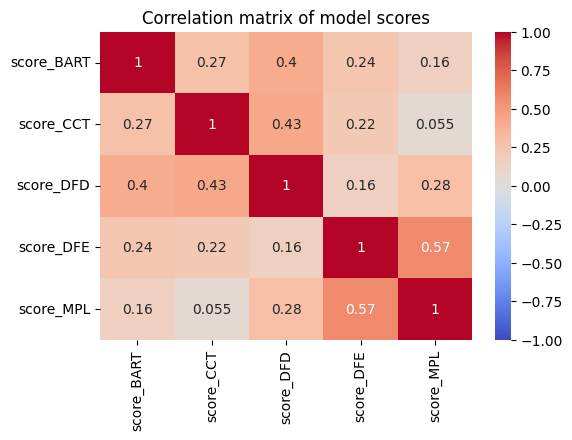

In [37]:
# Compute correlation matrix (only for numeric columns)
corr = all_data[["score_BART", "score_CCT", "score_DFD", "score_DFE", "score_MPL"]].corr()

# Display it as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix of model scores")
plt.show()


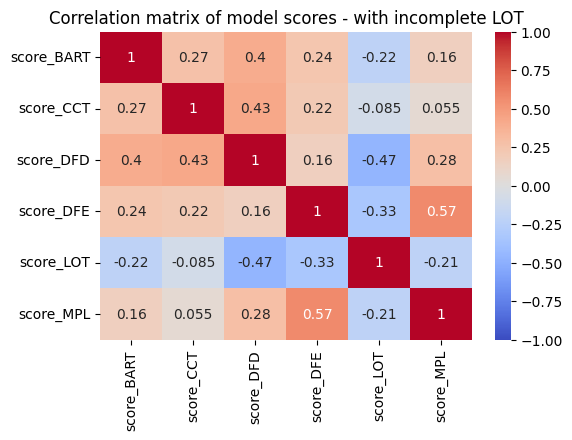

In [37]:
# Compute correlation matrix (only for numeric columns)
corr = all_data[["score_BART", "score_CCT", "score_DFD", "score_DFE", "score_LOT", "score_MPL"]].corr()

# Display it as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation matrix of model scores - with incomplete LOT")
plt.show()


### Takes:

Overall, very low variance in the data (all models have pretty much the same values)

The correlations between the tasks is really high, though!

(Reasons??? - simple statistical reasons?)

LOT only half, but correlates negatively! Any coding errors in the LOT task that would explain that? Or in the task logic?